# TF-IDF Feature Extraction and Model Training

This notebook performs TF-IDF feature extraction and trains multiple machine learning models for fake news detection.

## Overview
- Load preprocessed training data
- Optimize n-gram range using GridSearchCV
- Extract TF-IDF features
- Apply SMOTE for class balancing
- Train and evaluate multiple classifiers
- Generate performance visualizations


## 1. Import Required Libraries


In [1]:
import pandas as pd
import numpy as np

## 2. Load Preprocessed Training Data

Load the training dataset that has been cleaned and preprocessed in the data_cleaning notebook.


In [2]:
df = pd.read_csv("data/processed/train.csv", converters={'tokens': eval})

In [3]:
df

,title,text,subject,date,label,content,tokens,clean_text
0,BOILER ROOM: As the Frogs Slowly Boil – EP #40,Tune in to the Alternate Current Radio Network...,US_News,"January 20, 2016",0,boiler room: as the frogs slowly boil – ep #40...,"[boiler, room, frog, slowly, boil, ep, tune, a...",boiler room frog slowly boil ep tune alternate...
1,New Venezuela oil boss to give military more P...,CARACAS (Reuters) - A general appointed at the...,worldnews,"November 27, 2017",1,new venezuela oil boss to give military more p...,"[new, venezuela, oil, bos, give, military, pdv...",new venezuela oil bos give military pdvsa post...
2,Turkey says talk of ending its EU accession un...,ISTANBUL (Reuters) - Turkey s European Union A...,worldnews,"September 4, 2017",1,turkey says talk of ending its eu accession un...,"[turkey, say, talk, ending, eu, accession, und...",turkey say talk ending eu accession undermines...
3,SENATOR GILLIBRAND Pulled Strings So Muslim At...,Democrat Senator Kristen Gillibrand (NY) likes...,left-news,"Dec 12, 2017",0,senator gillibrand pulled strings so muslim at...,"[senator, gillibrand, pulled, string, muslim, ...",senator gillibrand pulled string muslim athlet...
4,Republican Trump says 'system is rigged' after...,WASHINGTON (Reuters) - U.S. Republican preside...,politicsNews,"July 5, 2016",1,republican trump says 'system is rigged' after...,"[republican, trump, say, rigged, clinton, emai...",republican trump say rigged clinton email anno...
...,...,...,...,...,...,...,...,...
35913,Trump Just FAILED Hundreds Of Manufacturing W...,"Last year, Trump claimed he was succeeding at ...",News,"May 7, 2017",0,trump just failed hundreds of manufacturing w...,"[trump, failed, hundred, manufacturing, worker...",trump failed hundred manufacturing worker blam...
35914,Judge Garland not interested in FBI job: sources,WASHINGTON (Reuters) - U.S. appeals court judg...,politicsNews,"May 16, 2017",1,judge garland not interested in fbi job: sourc...,"[judge, garland, interested, fbi, job, source,...",judge garland interested fbi job source washin...
35915,Expert On Voting Fraud DESTROYS Trump’s Lies ...,Terrified and unable to accept that he s destr...,News,"October 17, 2016",0,expert on voting fraud destroys trump’s lies ...,"[expert, voting, fraud, destroys, trump, lie, ...",expert voting fraud destroys trump lie blister...
35916,[Video] POLICE HAVE VERY GOOD REASON FOR BLOCK...,This mayor s involvement in potential illegal ...,politics,"Apr 24, 2015",0,[video] police have very good reason for block...,"[video, police, good, reason, blocking, newly,...",video police good reason blocking newly electe...


## Find the best variant feature set


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

# Use actual data from df
# X: texts; y: assume 'label' column holds labels (change if different)
X = df['clean_text'].values
y = df['label'].values  # <-- Make sure to replace with correct label column if it's different

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000))
])
pipeline.named_steps['tfidf'].set_params(max_features=10000)

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1)

grid.fit(X, y)

print("Best n-gram range:", grid.best_params_['tfidf__ngram_range'])
print("Best F1 score:", grid.best_score_)


Best n-gram range: (1, 3)
Best F1 score: 0.9762636427806706


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# Apply TF-IDF feature engineering with ngram_range (1,3) and max_features=10000
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), max_features=10000)
tfidf_features = tfidf_vectorizer.fit_transform(df['clean_text'].values)

# Save the TF-IDF matrix and the vectorizer as a tuple to pickle file
with open('tfidf_features_ngram_1_1.pkl', 'wb') as f:
    pickle.dump((tfidf_features, tfidf_vectorizer), f)


In [4]:
import pickle

with open('/home/root495/Inexture/Fake New Detection/tfidf_features_ngram_1_1.pkl', 'rb') as f:
    tfidf_features, tfidf_vectorizer = pickle.load(f)

## Apply SMOTE for Class Balancing

Use SMOTE (Synthetic Minority Oversampling Technique) to balance the class distribution in the training data.


In [5]:
from imblearn.over_sampling import SMOTE

# Use the same X and y as above
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(tfidf_features, df['label'].values)

print("Class distribution after SMOTE:", dict(zip(*np.unique(y_res, return_counts=True))))


Class distribution after SMOTE: {0: 18771, 1: 18771}


In [6]:
import pandas as pd

# Load test data
test_df = pd.read_csv("data/processed/test.csv")

# Transform test data into TF-IDF representation using the fitted vectorizer
X_test = tfidf_vectorizer.transform(test_df['clean_text'].values)
y_test = test_df["label"].values


## Logistic Regression - Hyper Parameter tuning & Model Evaluation

Train Logistic Regression with best hyperparameters and evaluate on test data.


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Train Logistic Regression on the balanced data using default parameters
logreg_default = LogisticRegression()
logreg_default.fit(X_res, y_res)

# Predict on the test set
y_pred_default = logreg_default.predict(X_test)
y_proba_default = logreg_default.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Logistic Regression (default) Test Accuracy:", accuracy_score(y_test, y_pred_default))
print("Logistic Regression (default) Test Precision:", precision_score(y_test, y_pred_default))
print("Logistic Regression (default) Test Recall:", recall_score(y_test, y_pred_default))
print("Logistic Regression (default) Test F1 Score:", f1_score(y_test, y_pred_default))
print("Logistic Regression (default) Test ROC AUC Score:", roc_auc_score(y_test, y_proba_default))




Logistic Regression (default) Test Accuracy: 0.987305122494432
Logistic Regression (default) Test Precision: 0.9830311483031148
Logistic Regression (default) Test Recall: 0.9903981264637002
Logistic Regression (default) Test F1 Score: 0.9867008866075595
Logistic Regression (default) Test ROC AUC Score: 0.9986825081917492


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Use the TF-IDF features already computed
X_tfidf = tfidf_features
y = df['label'].values  # Make sure this matches your label column name

# Set up the Logistic Regression and parameter grid
logreg = LogisticRegression(max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(logreg, param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid_search.fit(X_res, y_res)

print("Best Logistic Regression parameters:", grid_search.best_params_)
print("Best F1 score from Logistic Regression:", grid_search.best_score_)


Best Logistic Regression parameters: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
Best F1 score from Logistic Regression: 0.9947564619956404


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Train logistic regression on balanced data with the best parameters found
logreg = LogisticRegression(
    max_iter=1000, 
    random_state=42,
    C=100, 
    penalty='l2', 
    solver='saga'
)
logreg.fit(X_res, y_res)

# Predict on test data
y_test_pred = logreg.predict(X_test)
y_test_proba = logreg.predict_proba(X_test)[:,1] 

print("Logistic Regression metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))


Logistic Regression metrics on test data:
Precision: 0.9939067260370283
Recall: 0.993208430913349
F1 Score: 0.9935574557807192
Accuracy: 0.9938752783964365
ROC-AUC: 0.9995211742418593


## Naive Bayes - Hyperparameter Tuning & Model Evaluation

Perform hyperparameter tuning for Multinomial Naive Bayes classifier.


In [8]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes using default parameters
nb_default = MultinomialNB()
nb_default.fit(X_res, y_res)

# Predict on test data
y_test_pred_nb_default = nb_default.predict(X_test)
y_test_proba_nb_default = nb_default.predict_proba(X_test)[:, 1]

print("Naive Bayes (default) metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_nb_default))
print("Recall:", recall_score(y_test, y_test_pred_nb_default))
print("F1 Score:", f1_score(y_test, y_test_pred_nb_default))
print("Accuracy:", accuracy_score(y_test, y_test_pred_nb_default))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_nb_default))



Naive Bayes (default) metrics on test data:
Precision: 0.9409164922074901
Recall: 0.9473067915690867
F1 Score: 0.9441008285680943
Accuracy: 0.9466592427616927
ROC-AUC: 0.9861978350910168


In [17]:
from sklearn.naive_bayes import MultinomialNB

# Set up the Naive Bayes classifier and parameter grid
nb = MultinomialNB()
nb_param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1, 2, 5, 10],
    'fit_prior': [True, False]
}

nb_grid_search = GridSearchCV(nb, nb_param_grid, cv=cv, scoring='f1', n_jobs=-1)
nb_grid_search.fit(X_res, y_res)

print("Best Naive Bayes parameters:", nb_grid_search.best_params_)
print("Best F1 score from Naive Bayes:", nb_grid_search.best_score_)


Best Naive Bayes parameters: {'alpha': 0.01, 'fit_prior': True}
Best F1 score from Naive Bayes: 0.954099340436948


In [8]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes with best parameters
nb_best = MultinomialNB(alpha=0.01, fit_prior=True)
nb_best.fit(X_res, y_res)

# Predict on test data
y_test_pred_nb = nb_best.predict(X_test)
y_test_proba_nb = nb_best.predict_proba(X_test)[:, 1]

print("Naive Bayes metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_nb))
print("Recall:", recall_score(y_test, y_test_pred_nb))
print("F1 Score:", f1_score(y_test, y_test_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_test_pred_nb))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_nb))


Naive Bayes metrics on test data:
Precision: 0.9481756913781083
Recall: 0.955503512880562
F1 Score: 0.9518254986585792
Accuracy: 0.9540089086859688
ROC-AUC: 0.9892438729694655


## Decision Tree - Hyperparameter Tuning and model evaluation

Perform hyperparameter tuning for Decision Tree classifier.


In [10]:

from sklearn.tree import DecisionTreeClassifier

dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_res, y_res)

# Predict on test data
y_test_pred_dt_default = dt_default.predict(X_test)
y_test_proba_dt_default = dt_default.predict_proba(X_test)[:, 1]

print("Decision Tree (default parameters) metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_dt_default))
print("Recall:", recall_score(y_test, y_test_pred_dt_default))
print("F1 Score:", f1_score(y_test, y_test_pred_dt_default))
print("Accuracy:", accuracy_score(y_test, y_test_pred_dt_default))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_dt_default))



Decision Tree (default parameters) metrics on test data:
Precision: 0.995774647887324
Recall: 0.9934426229508196
F1 Score: 0.9946072684642439
Accuracy: 0.9948775055679288
ROC-AUC: 0.9948104834499322


In [18]:
from sklearn.tree import DecisionTreeClassifier

# Set up the Decision Tree classifier and parameter grid
dt = DecisionTreeClassifier(random_state=42)
dt_param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

dt_grid_search = GridSearchCV(dt, dt_param_grid, cv=cv, scoring='f1', n_jobs=-1)
dt_grid_search.fit(X_res, y_res)

print("Best Decision Tree parameters:", dt_grid_search.best_params_)
print("Best F1 score from Decision Tree:", dt_grid_search.best_score_)


Best Decision Tree parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best F1 score from Decision Tree: 0.9954486602167261


In [9]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree with best parameters
dt_best = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=42
)
dt_best.fit(X_res, y_res)

# Predict on test data
y_test_pred_dt = dt_best.predict(X_test)
y_test_proba_dt = dt_best.predict_proba(X_test)[:, 1]

print("Decision Tree metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_dt))
print("Recall:", recall_score(y_test, y_test_pred_dt))
print("F1 Score:", f1_score(y_test, y_test_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_test_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_dt))


Decision Tree metrics on test data:
Precision: 0.9939252336448599
Recall: 0.9962529274004683
F1 Score: 0.9950877192982456
Accuracy: 0.9953229398663697
ROC-AUC: 0.9947571562821642


## Random Forest - Hyperparameter tuning & Model Evaluation

Train Random Forest with best hyperparameters and evaluate on test data.


In [11]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest with default parameters
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_res, y_res)

# Predict on test data
y_test_pred_rf_default = rf_default.predict(X_test)
y_test_proba_rf_default = rf_default.predict_proba(X_test)[:, 1]

print("Random Forest (default) metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_rf_default))
print("Recall:", recall_score(y_test, y_test_pred_rf_default))
print("F1 Score:", f1_score(y_test, y_test_pred_rf_default))
print("Accuracy:", accuracy_score(y_test, y_test_pred_rf_default))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_rf_default))


Random Forest (default) metrics on test data:
Precision: 0.9960178027641133
Recall: 0.9957845433255269
F1 Score: 0.995901159386345
Accuracy: 0.9961024498886414
ROC-AUC: 0.9997117598213975


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Set up the Random Forest classifier and parameter distributions
rf = RandomForestClassifier(random_state=42)
rf_param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(
    rf,
    rf_param_dist,
    n_iter=2,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rf_random_search.fit(X_res, y_res)

print("Best Random Forest parameters from RandomizedSearchCV:", rf_random_search.best_params_)
print("Best F1 score from Random Forest (RandomizedSearchCV):", rf_random_search.best_score_)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Random Forest parameters from RandomizedSearchCV: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best F1 score from Random Forest (RandomizedSearchCV): 0.9975268103645627


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest with best parameters from RandomizedSearchCV
rf_best = RandomForestClassifier(
    n_estimators=500,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=None,
    bootstrap=False,
    random_state=42
)
rf_best.fit(X_res, y_res)

# Predict on test data
y_test_pred_rf = rf_best.predict(X_test)
y_test_proba_rf = rf_best.predict_proba(X_test)[:, 1]

print("Random Forest metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_rf))
print("Recall:", recall_score(y_test, y_test_pred_rf))
print("F1 Score:", f1_score(y_test, y_test_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_rf)) 


Random Forest metrics on test data:
Precision: 0.9967220791383751
Recall: 0.9969555035128805
F1 Score: 0.9968387776606955
Accuracy: 0.9969933184855234
ROC-AUC: 0.9998080221960353


## 17. AdaBoost - Model Evaluation

Train AdaBoost with best hyperparameters and evaluate on test data.


In [12]:
from sklearn.ensemble import AdaBoostClassifier

# Train AdaBoost with default parameters
ada_default = AdaBoostClassifier(random_state=42)
ada_default.fit(X_res, y_res)

# Predict on test data
y_test_pred_ada_default = ada_default.predict(X_test)
y_test_proba_ada_default = ada_default.predict_proba(X_test)[:, 1]

print("AdaBoost (default parameters) metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_ada_default))
print("Recall:", recall_score(y_test, y_test_pred_ada_default))
print("F1 Score:", f1_score(y_test, y_test_pred_ada_default))
print("Accuracy:", accuracy_score(y_test, y_test_pred_ada_default))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_ada_default))


AdaBoost (default parameters) metrics on test data:
Precision: 0.9913853317811409
Recall: 0.9971896955503513
F1 Score: 0.9942790426152948
Accuracy: 0.994543429844098
ROC-AUC: 0.999122003609839


In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# Set up the AdaBoost classifier and parameter distributions
ada = AdaBoostClassifier(random_state=42)
ada_param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

ada_random_search = RandomizedSearchCV(
    ada,
    ada_param_dist,
    n_iter=2,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
ada_random_search.fit(X_res, y_res)

print("Best AdaBoost parameters from RandomizedSearchCV:", ada_random_search.best_params_)
print("Best F1 score from AdaBoost (RandomizedSearchCV):", ada_random_search.best_score_)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/root495/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/root495/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/root495/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/root495/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/root495/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWa

Best AdaBoost parameters from RandomizedSearchCV: {'n_estimators': 50, 'learning_rate': 0.05, 'algorithm': 'SAMME'}
Best F1 score from AdaBoost (RandomizedSearchCV): 0.9931889808956736


In [13]:
from sklearn.ensemble import AdaBoostClassifier

# Train AdaBoost with best parameters from RandomizedSearchCV
ada_best = AdaBoostClassifier(
    n_estimators=50,
    learning_rate=0.05,
    algorithm='SAMME',
    random_state=42
)
ada_best.fit(X_res, y_res)

# Predict on test data
y_test_pred_ada = ada_best.predict(X_test)
y_test_proba_ada = ada_best.predict_proba(X_test)[:, 1]

print("AdaBoost metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_ada))
print("Recall:", recall_score(y_test, y_test_pred_ada))
print("F1 Score:", f1_score(y_test, y_test_pred_ada))
print("Accuracy:", accuracy_score(y_test, y_test_pred_ada))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_ada))


/home/root495/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost metrics on test data:
Precision: 0.9886258124419685
Recall: 0.997423887587822
F1 Score: 0.9930053625553742
Accuracy: 0.9933184855233853
ROC-AUC: 0.997134677824351


## 19. Gradient Boosting - Model Evaluation

Train Gradient Boosting with best hyperparameters and evaluate on test data.


In [13]:
from sklearn.ensemble import GradientBoostingClassifier

# Train GradientBoostingClassifier with default hyperparameters
gb_default = GradientBoostingClassifier(random_state=42)
gb_default.fit(X_res, y_res)

# Predict on test data
y_test_pred_gb = gb_default.predict(X_test)
y_test_proba_gb = gb_default.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("GradientBoostingClassifier (default params) metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_gb))
print("Recall:", recall_score(y_test, y_test_pred_gb))
print("F1 Score:", f1_score(y_test, y_test_pred_gb))
print("Accuracy:", accuracy_score(y_test, y_test_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_gb))


GradientBoostingClassifier (default params) metrics on test data:
Precision: 0.9934594720859612
Recall: 0.9960187353629977
F1 Score: 0.9947374576072974
Accuracy: 0.994988864142539
ROC-AUC: 0.9976602674065346


In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Set up the Gradient Boosting classifier and parameter distributions
gb = GradientBoostingClassifier(random_state=42)
gb_param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

gb_random_search = RandomizedSearchCV(
    gb,
    gb_param_dist,
    n_iter=2,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
gb_random_search.fit(X_res, y_res)

print("Best Gradient Boosting parameters from RandomizedSearchCV:", gb_random_search.best_params_)
print("Best F1 score from Gradient Boosting (RandomizedSearchCV):", gb_random_search.best_score_)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Gradient Boosting parameters from RandomizedSearchCV: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 6, 'learning_rate': 0.01}
Best F1 score from Gradient Boosting (RandomizedSearchCV): 0.9954565312389375


In [14]:
from sklearn.ensemble import GradientBoostingClassifier

# Set up the Gradient Boosting Classifier with best hyperparameters from RandomizedSearchCV
gb_clf = GradientBoostingClassifier(
    subsample=1.0,
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=4,
    max_depth=6,
    learning_rate=0.01,
    random_state=42
)

# Train on resampled data
gb_clf.fit(X_res, y_res)

# Predict on test data
y_test_pred_gb = gb_clf.predict(X_test)
y_test_proba_gb = gb_clf.predict_proba(X_test)[:, 1]

print("Gradient Boosting metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_gb))
print("Recall:", recall_score(y_test, y_test_pred_gb))
print("F1 Score:", f1_score(y_test, y_test_pred_gb))
print("Accuracy:", accuracy_score(y_test, y_test_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_gb))


Gradient Boosting metrics on test data:
Precision: 0.9934640522875817
Recall: 0.9967213114754099
F1 Score: 0.9950900163666121
Accuracy: 0.9953229398663697
ROC-AUC: 0.9972985128059788


##  XGBoost - Model Hyper parametermeter tuning and Evaluation

Train XGBoost with best hyperparameters and evaluate on test data.


In [14]:
from xgboost import XGBClassifier

# Train XGBoost classifier with default parameters
xgb_default = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_default.fit(X_res, y_res)

# Predict on test data
y_test_pred_xgb_default = xgb_default.predict(X_test)
y_test_proba_xgb_default = xgb_default.predict_proba(X_test)[:, 1]

print("XGBoost (default parameters) metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_xgb_default))
print("Recall:", recall_score(y_test, y_test_pred_xgb_default))
print("F1 Score:", f1_score(y_test, y_test_pred_xgb_default))
print("Accuracy:", accuracy_score(y_test, y_test_pred_xgb_default))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_xgb_default))


/home/root495/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:26:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (default parameters) metrics on test data:
Precision: 0.9969569288389513
Recall: 0.997423887587822
F1 Score: 0.9971903535471787
Accuracy: 0.9973273942093541
ROC-AUC: 0.9997478830730372


In [ ]:
from xgboost import XGBClassifier

# Set up the XGBoost classifier and parameter distributions
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 1, 2],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 5, 10]
}

xgb_random_search = RandomizedSearchCV(
    xgb,
    xgb_param_dist,
    n_iter=2,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
xgb_random_search.fit(X_res, y_res)

print("Best XGBoost parameters from RandomizedSearchCV:", xgb_random_search.best_params_)
print("Best F1 score from XGBoost (RandomizedSearchCV):", xgb_random_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/root495/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:08:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/root495/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:08:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/root495/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:08:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/root495/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:08:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/root495/.local/lib/python3.10/site-packages/xgboost/tr

Best XGBoost parameters from RandomizedSearchCV: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.5, 'gamma': 1, 'colsample_bytree': 0.7}
Best F1 score from XGBoost (RandomizedSearchCV): 0.997285697806638


In [ ]:
from xgboost import XGBClassifier

# Set up the XGBoost Classifier with best-found hyperparameters from RandomizedSearchCV
xgb_clf = XGBClassifier(
    n_estimators=500,
    learning_rate=0.5,
    max_depth=6,
    subsample=1.0,
    colsample_bytree=0.7,
    gamma=1,
    reg_alpha=1,
    reg_lambda=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model on the resampled training data
xgb_clf.fit(X_res, y_res)

# Predict on the test data
y_test_pred_xgb = xgb_clf.predict(X_test)
y_test_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

print("XGBoost metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_xgb))
print("Recall:", recall_score(y_test, y_test_pred_xgb))
print("F1 Score:", f1_score(y_test, y_test_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_test_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_xgb))


/home/root495/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:08:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost metrics on test data:
Precision: 0.9962555581558624
Recall: 0.9969555035128805
F1 Score: 0.9966054079363221
Accuracy: 0.9967706013363029
ROC-AUC: 0.9995833271180457


In [7]:
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score


# Train SVM with default parameters
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_res, y_res)

# Predict on the test data
y_test_pred_svm = svm_clf.predict(X_test)
y_test_proba_svm = svm_clf.predict_proba(X_test)[:, 1]

print("SVM (default parameters) metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_svm))
print("Recall:", recall_score(y_test, y_test_pred_svm))
print("F1 Score:", f1_score(y_test, y_test_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_test_pred_svm))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_svm))


SVM (default parameters) metrics on test data:
Precision: 0.991359177954227
Recall: 0.9941451990632318
F1 Score: 0.9927502338634238
Accuracy: 0.9930957683741648
ROC-AUC: 0.9994727944430357


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Initialize SVM with probability=True for later predict_proba use
svm_gs_clf = SVC(probability=True, random_state=42)

# GridSearchCV with 5-fold cross validation
svm_grid_search = GridSearchCV(
    estimator=svm_gs_clf,
    param_grid=svm_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

# Fit on the resampled training data
svm_grid_search.fit(X_res, y_res)

# Display the best parameters only
print("Best SVM parameters found by GridSearchCV:", svm_grid_search.best_params_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=2; total time=12.2min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=2; total time=12.2min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=2; total time=12.2min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=2; total time=12.2min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=2; total time=12.2min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=3; total time=13.2min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=3; total time=13.2min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=3; total time=13.2min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=3; total time=13.2min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=3; total time=13.2min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=4; total time=10.1min
[CV] END ........C=0.1, kernel=linear, gamma=sc

In [10]:
# Train a new SVM classifier with the best found parameters

svm_best_clf = SVC(
    C=5,
    degree=1,
    gamma='scale',
    kernel='rbf',
    probability=True,
    random_state=42
)

# Fit the classifier on the resampled training data
svm_best_clf.fit(X_res, y_res)

# Predict on the test data using the best estimator
y_test_pred_svm_best = svm_best_clf.predict(X_test)
y_test_proba_svm_best = svm_best_clf.predict_proba(X_test)[:, 1]

print("SVM (best parameters) metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_svm_best))
print("Recall:", recall_score(y_test, y_test_pred_svm_best))
print("F1 Score:", f1_score(y_test, y_test_pred_svm_best))
print("Accuracy:", accuracy_score(y_test, y_test_pred_svm_best))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_svm_best))


SVM (best parameters) metrics on test data:
Precision: 0.9925163704396632
Recall: 0.9939110070257611
F1 Score: 0.9932131991575006
Accuracy: 0.9935412026726058
ROC-AUC: 0.9995235609123048


## Model metric Comparison

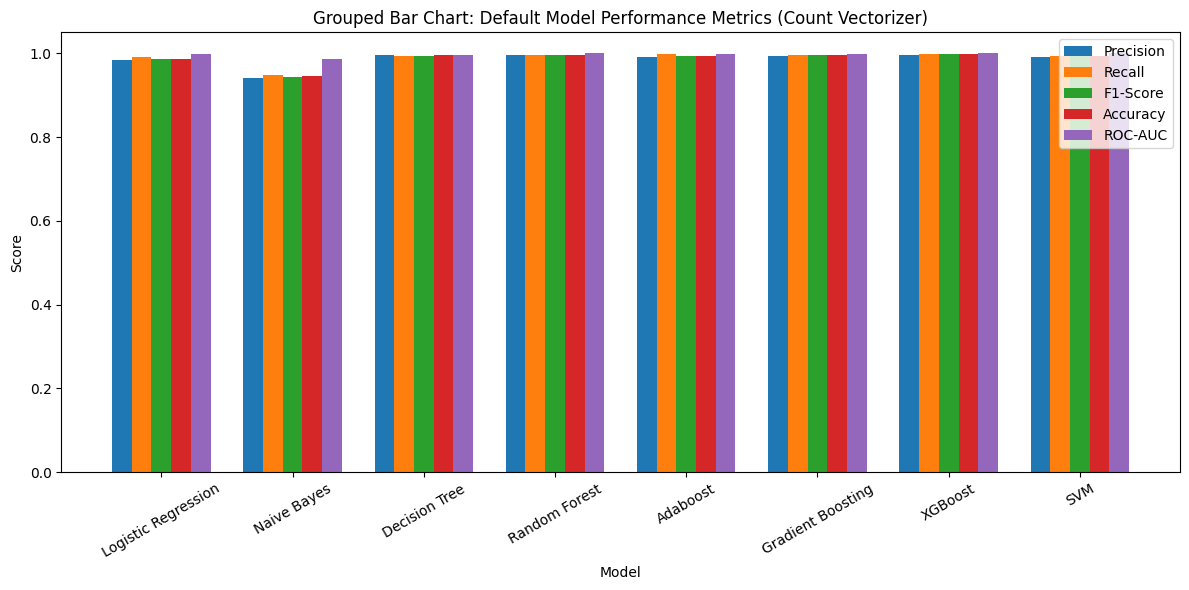

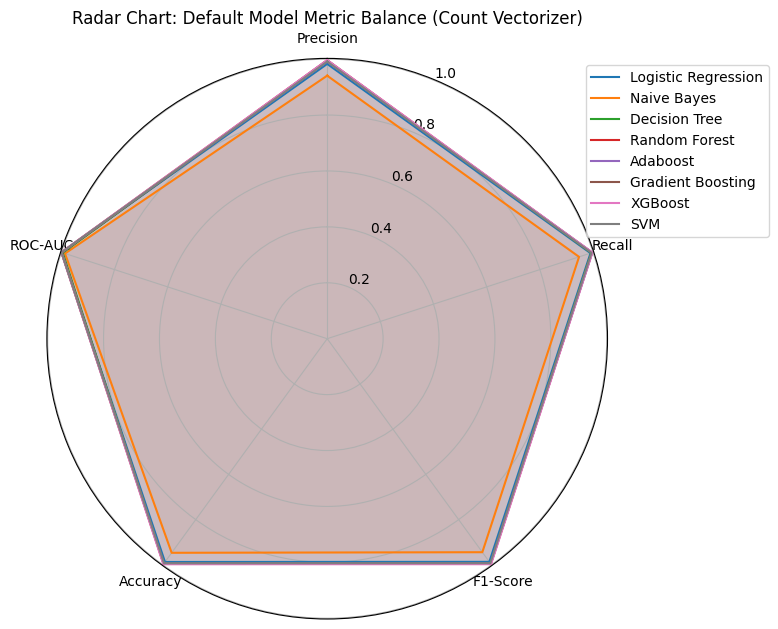

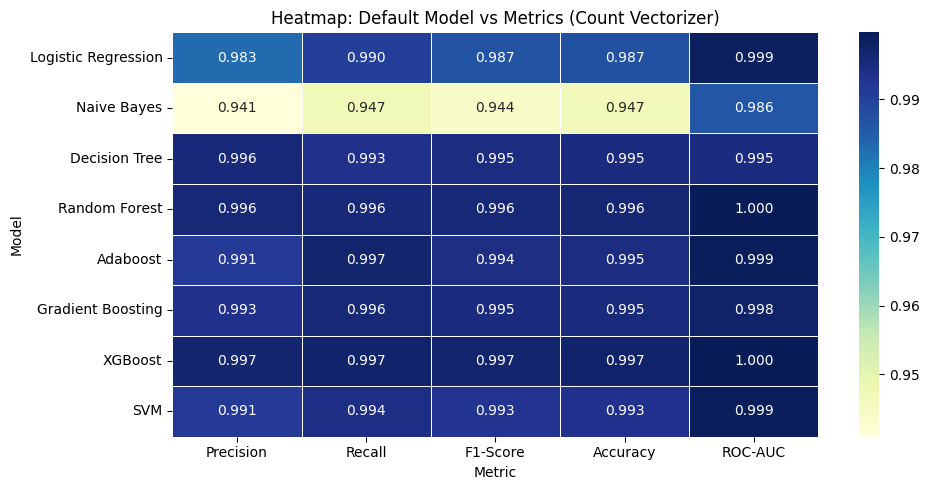

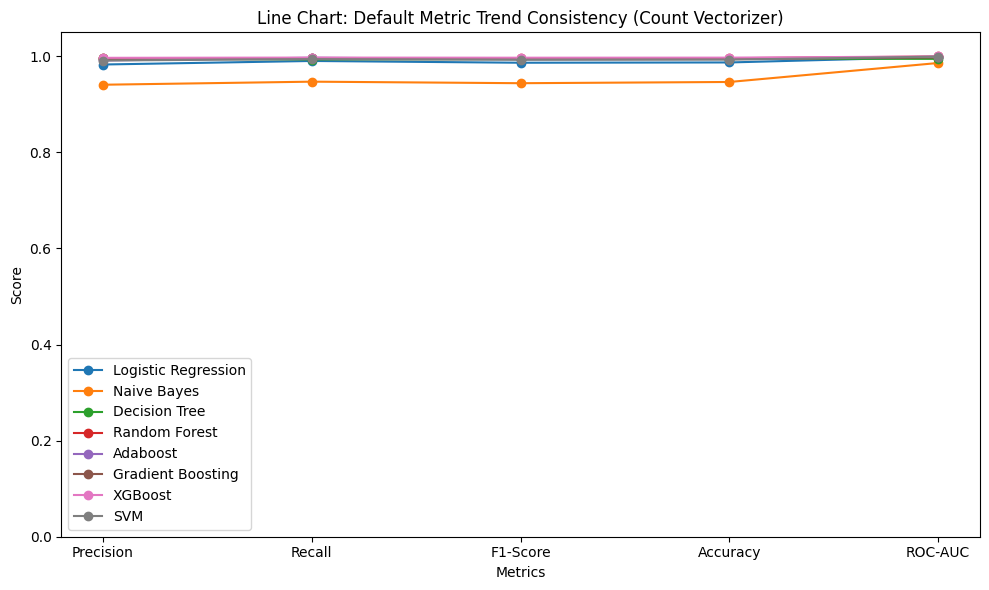

/tmp/ipykernel_144205/3313102537.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mean_Score', y=model_col, data=ranking_df_default, palette="viridis")


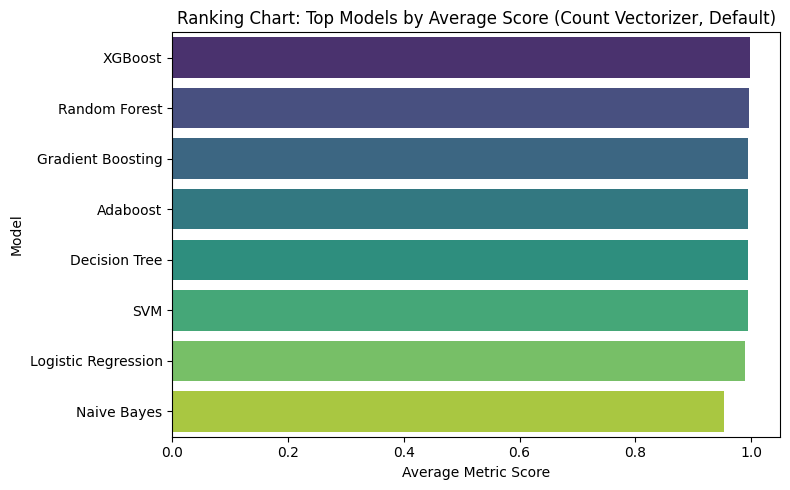

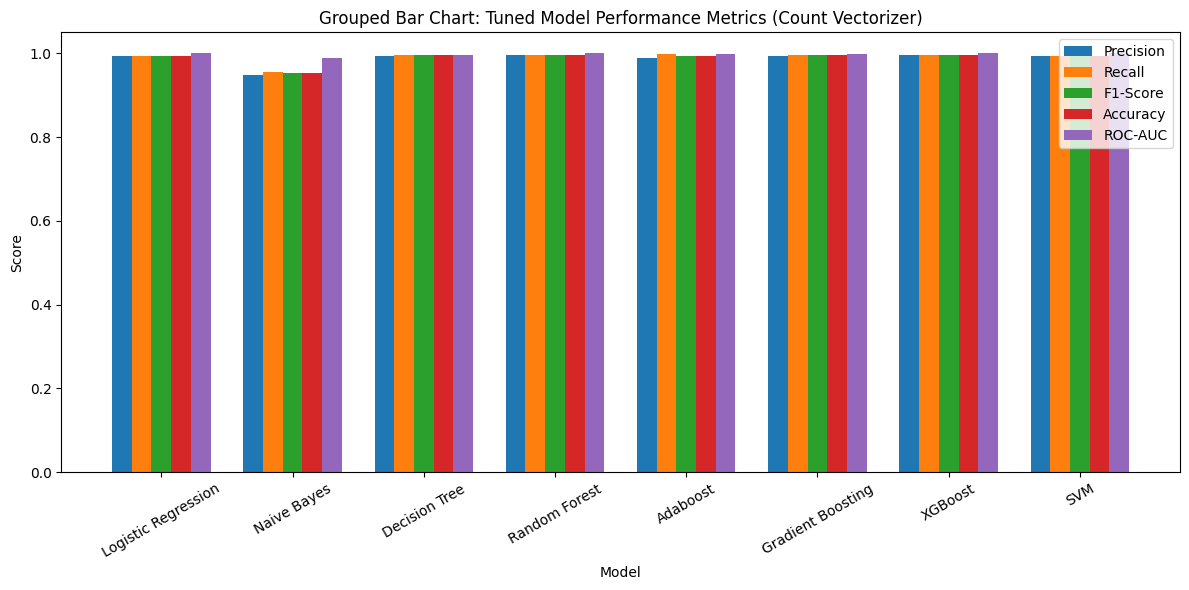

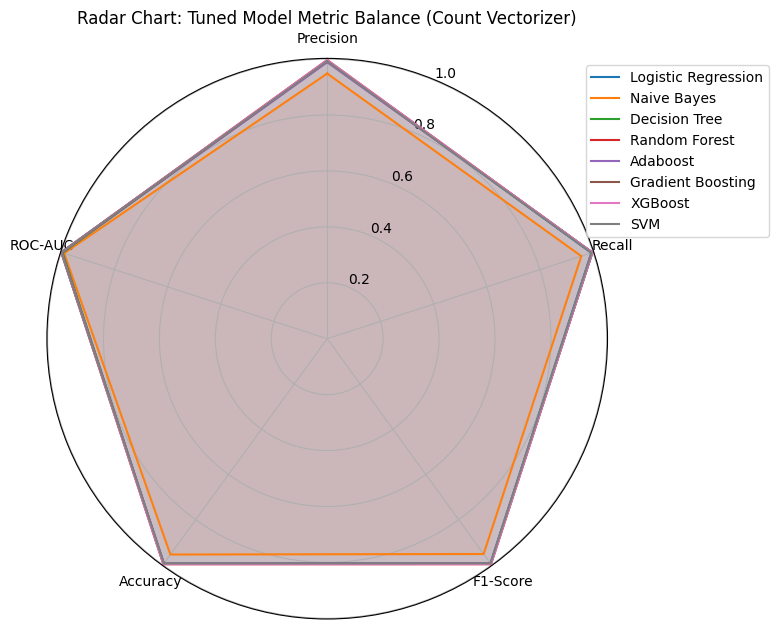

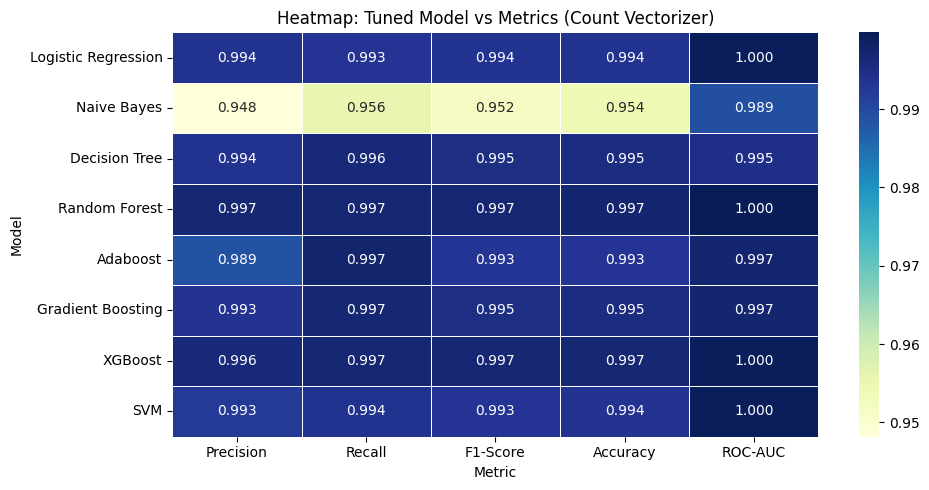

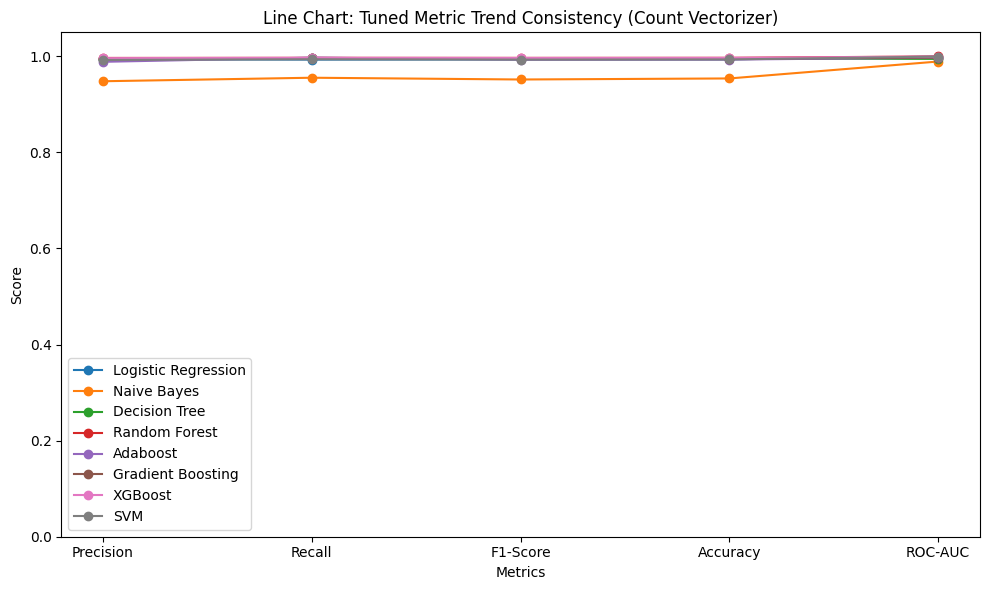

/tmp/ipykernel_144205/3313102537.py:196: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mean_Score', y=model_col, data=ranking_df_tuned, palette="viridis")


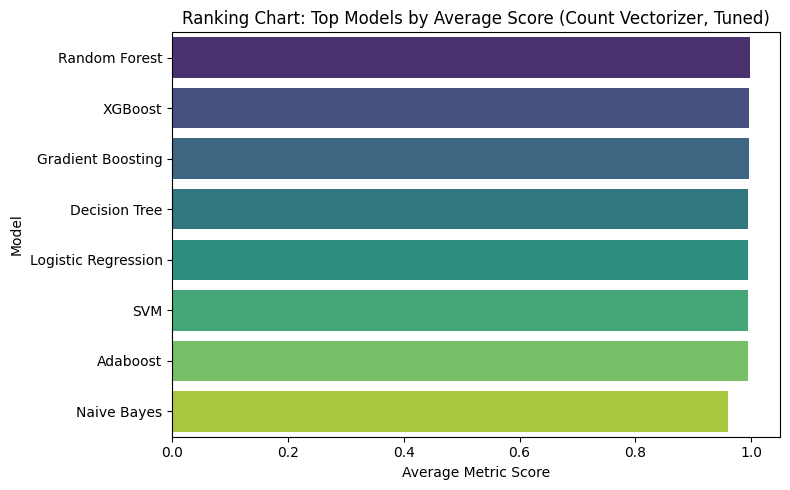

/tmp/ipykernel_144205/3313102537.py:235: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


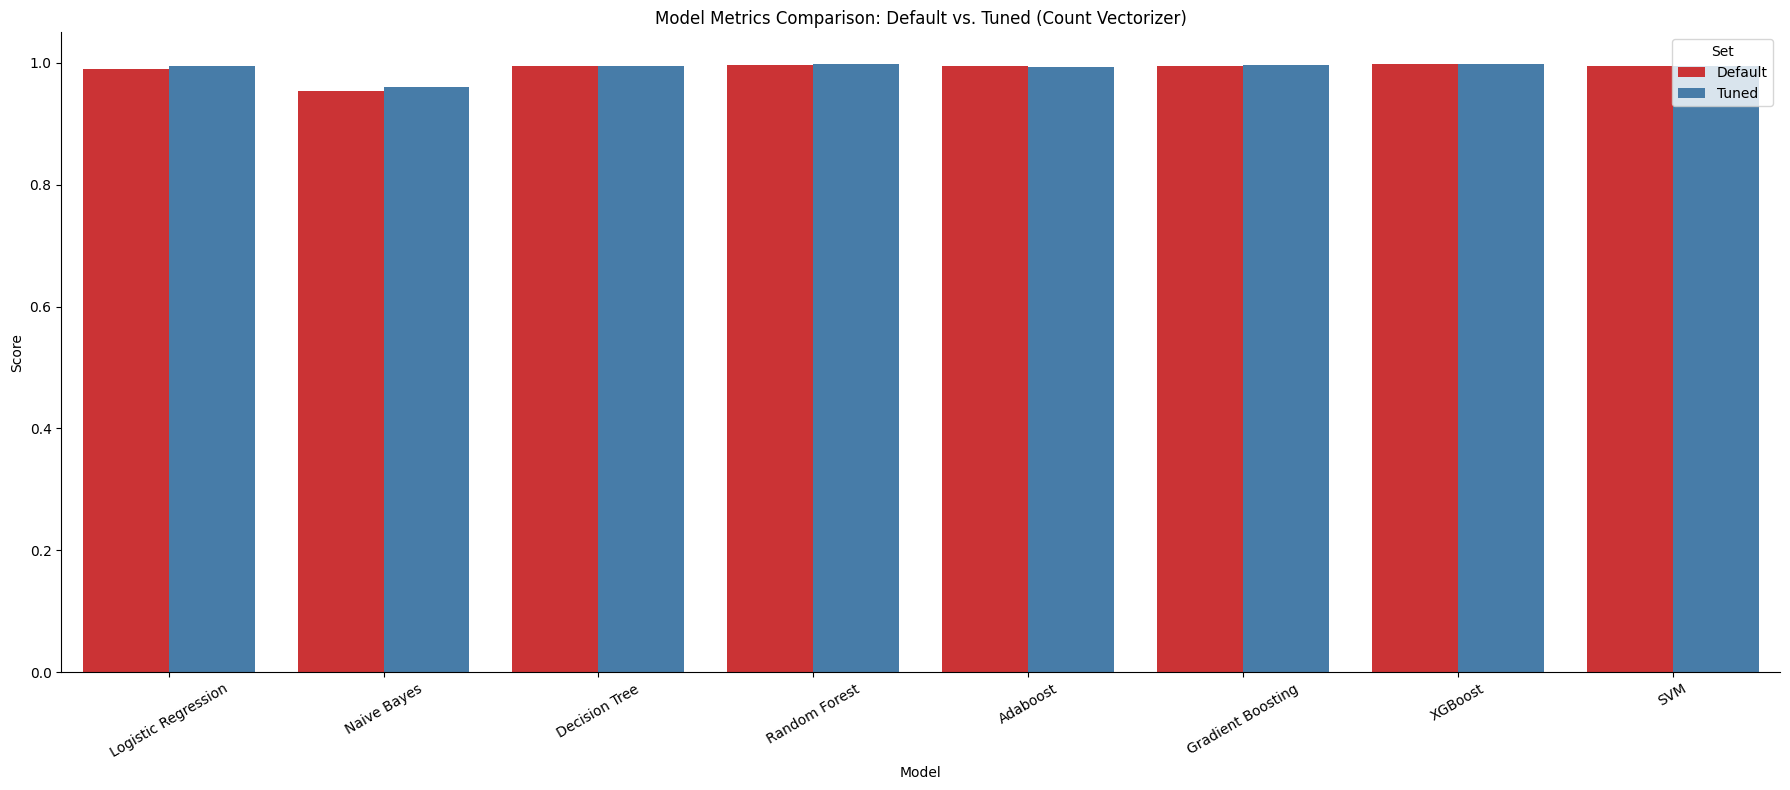

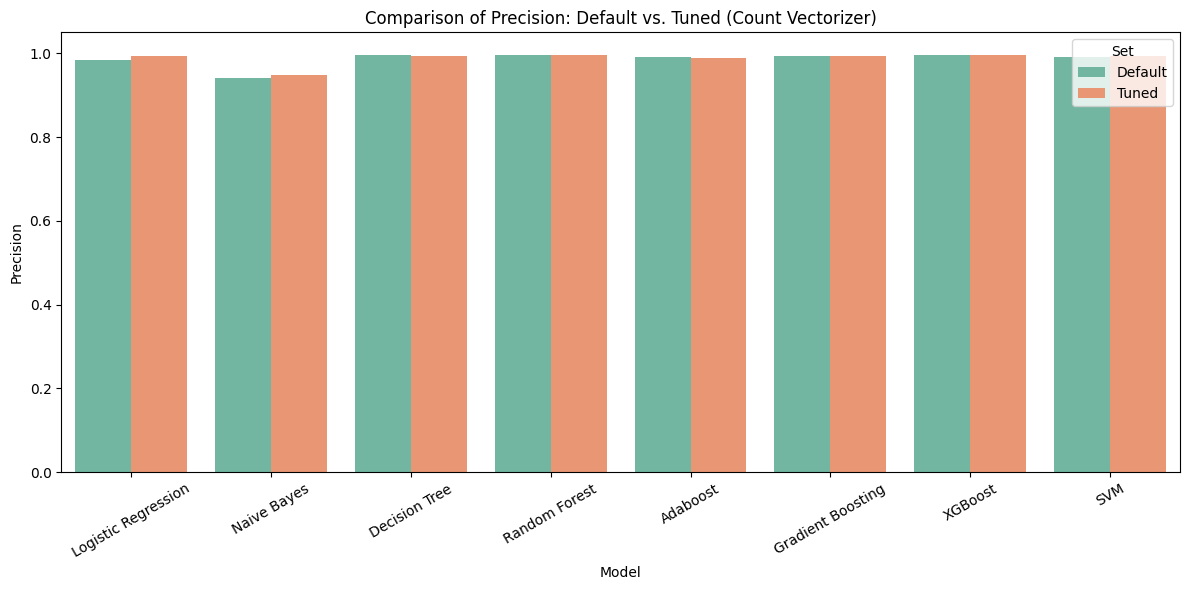

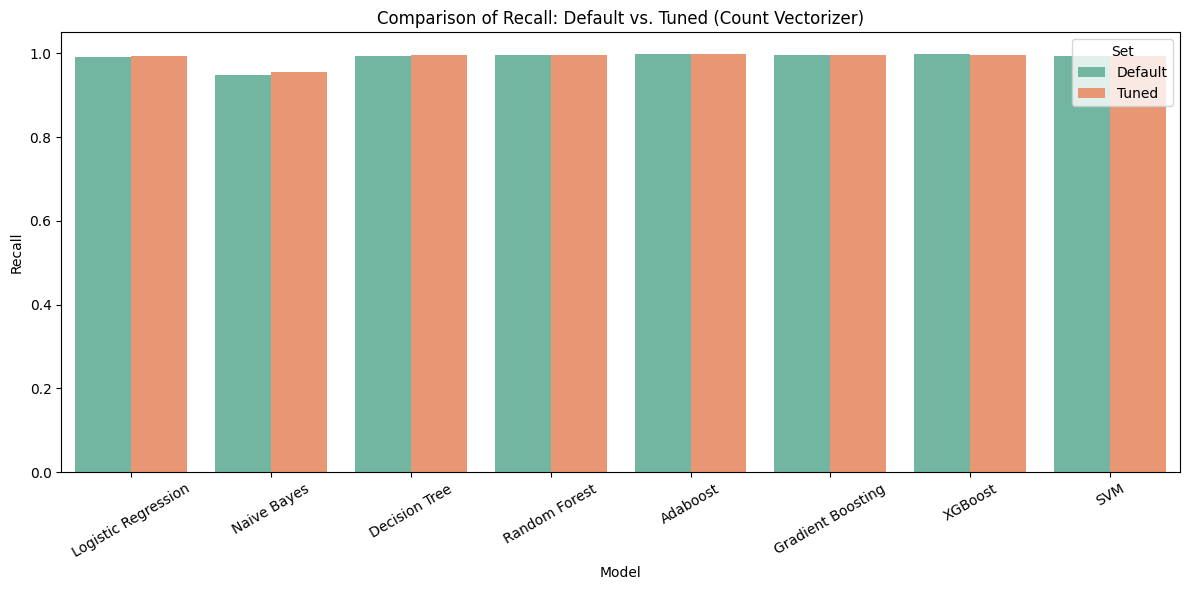

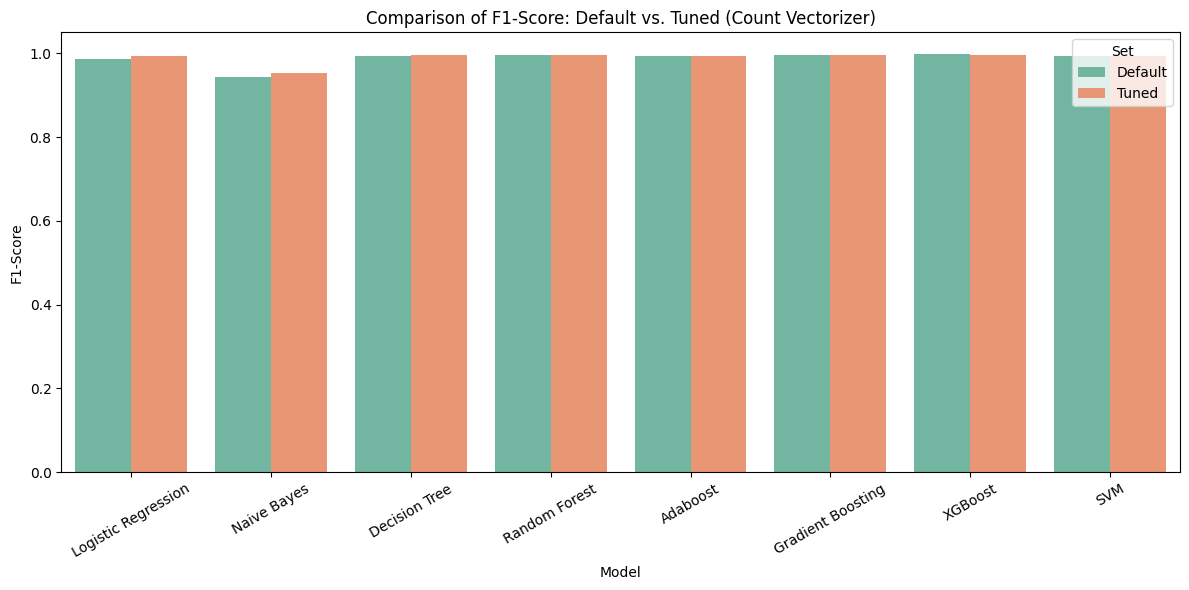

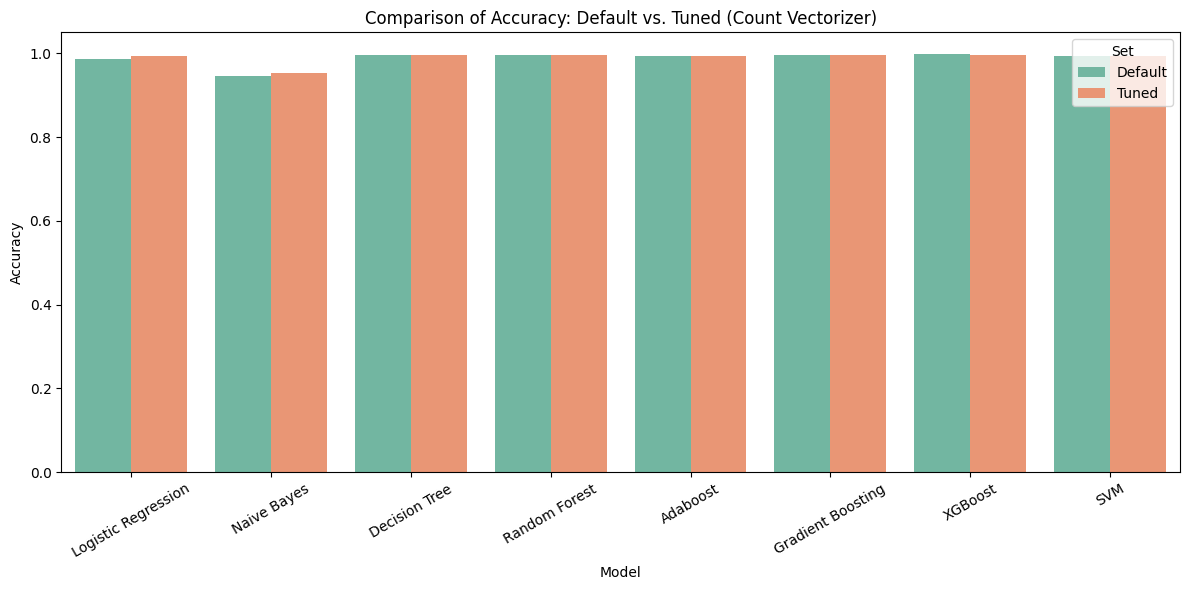

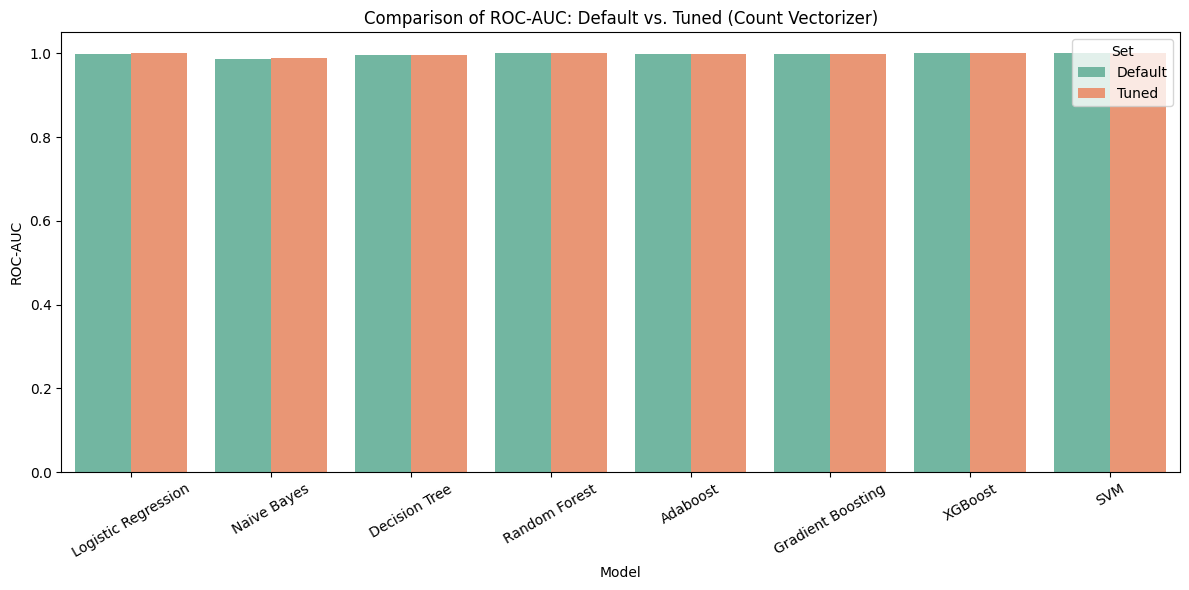

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Paths and Configurations
# ==============================
# Input CSVs
default_csv_path = "/home/root495/Inexture/Fake New Detection/data/result/TFIDF_default_metrics.csv"
tuned_csv_path   = "/home/root495/Inexture/Fake New Detection/data/result/TFIDF_tuned_metrics.csv"

# Output graph directory (as instructed)
graph_dir = "/home/root495/Inexture/Fake New Detection/data/result/graph/tfidf"
os.makedirs(graph_dir, exist_ok=True)

# Metric and label columns
model_col = "Model"
# The ROC-AUC metric is named literally "ROC-AUC" in the CSVs
roc_auc_col = "ROC-AUC"

# Compose the metric column lists for each DataFrame accordingly
base_metric_cols = ["Precision", "Recall", "F1-Score", "Accuracy"]
metric_cols_default = [col for col in base_metric_cols] + [roc_auc_col]
metric_cols_tuned   = [col for col in base_metric_cols] + [roc_auc_col]

default_df = pd.read_csv(default_csv_path)
tuned_df = pd.read_csv(tuned_csv_path)

# Ensure all metric columns are numeric (for robust plotting)
for df, metric_cols in zip([default_df, tuned_df], [metric_cols_default, metric_cols_tuned]):
    for col in metric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# ==============================
# Plot: Default Models
# ==============================
models = default_df[model_col].tolist()
metrics = default_df[metric_cols_default]

# ----------- Grouped Bar Chart: DEFAULT -----------
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.15
index = np.arange(len(models))
for i, metric in enumerate(metric_cols_default):
    plt.bar(index + i*bar_width, metrics[metric], bar_width, label=metric)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Grouped Bar Chart: Default Model Performance Metrics (Count Vectorizer)')
plt.xticks(index + bar_width*2, models, rotation=30)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
grouped_bar_path = os.path.join(graph_dir, "grouped_bar_chart_countvectorizer_default.png")
plt.savefig(grouped_bar_path)
plt.show()

# ----------- Radar Chart: DEFAULT -----------
num_vars = len(metric_cols_default)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, row in default_df.iterrows():
    values = row[metric_cols_default].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row[model_col])
    ax.fill(angles, values, alpha=0.08)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metric_cols_default)
plt.title("Radar Chart: Default Model Metric Balance (Count Vectorizer)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
radar_path = os.path.join(graph_dir, "radar_chart_countvectorizer_default.png")
plt.savefig(radar_path)
plt.show()

# ----------- Heatmap: DEFAULT -----------
plt.figure(figsize=(10, 5))
heatmap_data = metrics.copy()
heatmap_data.index = models
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=0.5)
plt.title('Heatmap: Default Model vs Metrics (Count Vectorizer)')
plt.ylabel('Model')
plt.xlabel('Metric')
plt.tight_layout()
heatmap_path = os.path.join(graph_dir, "heatmap_countvectorizer_default.png")
plt.savefig(heatmap_path)
plt.show()

# ----------- Line Chart: DEFAULT -----------
plt.figure(figsize=(10, 6))
for m in models:
    row = default_df[default_df[model_col] == m]
    plt.plot(metric_cols_default, row[metric_cols_default].values[0], marker='o', label=m)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Line Chart: Default Metric Trend Consistency (Count Vectorizer)')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
line_chart_path = os.path.join(graph_dir, "line_chart_countvectorizer_default.png")
plt.savefig(line_chart_path)
plt.show()

# ----------- Ranking Chart: DEFAULT -----------
default_df['Mean_Score'] = default_df[metric_cols_default].mean(axis=1)
ranking_df_default = default_df.sort_values('Mean_Score', ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x='Mean_Score', y=model_col, data=ranking_df_default, palette="viridis")
plt.xlabel('Average Metric Score')
plt.ylabel('Model')
plt.title('Ranking Chart: Top Models by Average Score (Count Vectorizer, Default)')
plt.xlim(0, 1.05)
plt.tight_layout()
ranking_chart_path = os.path.join(graph_dir, "ranking_chart_countvectorizer_default.png")
plt.savefig(ranking_chart_path)
plt.show()

# ==============================
# Plot: Tuned Models
# ==============================
models_tuned = tuned_df[model_col].tolist()
metrics_tuned = tuned_df[metric_cols_tuned]

# ----------- Grouped Bar Chart: TUNED -----------
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.15
index = np.arange(len(models_tuned))
for i, metric in enumerate(metric_cols_tuned):
    plt.bar(index + i*bar_width, metrics_tuned[metric], bar_width, label=metric)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Grouped Bar Chart: Tuned Model Performance Metrics (Count Vectorizer)')
plt.xticks(index + bar_width*2, models_tuned, rotation=30)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
grouped_bar_path_tuned = os.path.join(graph_dir, "grouped_bar_chart_countvectorizer_tuned.png")
plt.savefig(grouped_bar_path_tuned)
plt.show()

# ----------- Radar Chart: TUNED -----------
num_vars = len(metric_cols_tuned)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, row in tuned_df.iterrows():
    values = row[metric_cols_tuned].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row[model_col])
    ax.fill(angles, values, alpha=0.08)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metric_cols_tuned)
plt.title("Radar Chart: Tuned Model Metric Balance (Count Vectorizer)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
radar_path_tuned = os.path.join(graph_dir, "radar_chart_countvectorizer_tuned.png")
plt.savefig(radar_path_tuned)
plt.show()

# ----------- Heatmap: TUNED -----------
plt.figure(figsize=(10, 5))
heatmap_data_tuned = metrics_tuned.copy()
heatmap_data_tuned.index = models_tuned
sns.heatmap(heatmap_data_tuned, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=0.5)
plt.title('Heatmap: Tuned Model vs Metrics (Count Vectorizer)')
plt.ylabel('Model')
plt.xlabel('Metric')
plt.tight_layout()
heatmap_path_tuned = os.path.join(graph_dir, "heatmap_countvectorizer_tuned.png")
plt.savefig(heatmap_path_tuned)
plt.show()

# ----------- Line Chart: TUNED -----------
plt.figure(figsize=(10, 6))
for m in models_tuned:
    row = tuned_df[tuned_df[model_col] == m]
    plt.plot(metric_cols_tuned, row[metric_cols_tuned].values[0], marker='o', label=m)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Line Chart: Tuned Metric Trend Consistency (Count Vectorizer)')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
line_chart_path_tuned = os.path.join(graph_dir, "line_chart_countvectorizer_tuned.png")
plt.savefig(line_chart_path_tuned)
plt.show()

# ----------- Ranking Chart: TUNED -----------
tuned_df['Mean_Score'] = tuned_df[metric_cols_tuned].mean(axis=1)
ranking_df_tuned = tuned_df.sort_values('Mean_Score', ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x='Mean_Score', y=model_col, data=ranking_df_tuned, palette="viridis")
plt.xlabel('Average Metric Score')
plt.ylabel('Model')
plt.title('Ranking Chart: Top Models by Average Score (Count Vectorizer, Tuned)')
plt.xlim(0, 1.05)
plt.tight_layout()
ranking_chart_path_tuned = os.path.join(graph_dir, "ranking_chart_countvectorizer_tuned.png")
plt.savefig(ranking_chart_path_tuned)
plt.show()

# ==============================
# COMPARISON PLOT: Default vs. Tuned
# ==============================
# For the purposes of comparison, map to a unified name (for e.g., always as 'ROC-AUC')
metric_col_map = {name: name for name in base_metric_cols}
metric_col_map[roc_auc_col] = "ROC-AUC"

compare_default_df = default_df[[model_col] + metric_cols_default].copy().rename(columns=metric_col_map)
compare_tuned_df = tuned_df[[model_col] + metric_cols_tuned].copy().rename(columns=metric_col_map)

compare_default_df['Set'] = 'Default'
compare_tuned_df['Set'] = 'Tuned'
metric_cols_compare = base_metric_cols + ["ROC-AUC"]

compare_df = pd.concat([
    compare_default_df[[model_col, "Set"] + metric_cols_compare], 
    compare_tuned_df[[model_col, "Set"] + metric_cols_compare]
], ignore_index=True)

# Melt for grouped barplot
melted_compare = compare_df.melt(
    id_vars=[model_col, "Set"], 
    value_vars=metric_cols_compare, 
    var_name='Metric', 
    value_name='Score'
)

plt.figure(figsize=(18, 8))
# We'll do a grouped bar by metric
sns.barplot(
    data=melted_compare, 
    x='Model', y='Score', 
    hue='Set', 
    ci=None, 
    palette='Set1',
    errorbar=None
)
sns.despine()
plt.subplots_adjust(top=0.85)
plt.title("Model Metrics Comparison: Default vs. Tuned (Count Vectorizer)")
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=30)
comparison_graph_path = os.path.join(graph_dir, "comparison_bar_chart_countvectorizer_default_vs_tuned.png")
plt.tight_layout()
plt.savefig(comparison_graph_path)
plt.show()

# Also, comparison as a grouped bar for each metric
for metric in metric_cols_compare:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=melted_compare[melted_compare["Metric"] == metric],
        x='Model', y='Score', hue='Set', palette='Set2',
        errorbar=None
    )
    plt.ylim(0, 1.05)
    plt.title(f"Comparison of {metric}: Default vs. Tuned (Count Vectorizer)")
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=30)
    plt.tight_layout()
    metric_path = os.path.join(graph_dir, f"comparison_bar_{metric.lower().replace('-', '_')}_default_vs_tuned.png")
    plt.savefig(metric_path)
    plt.show()
